In [1]:
# Importing required libraries 

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
CATEGORIES = ['COVID','non-COVID']
DATA_DIR = 'sars'
train_dir = os.path.join(DATA_DIR)

In [4]:
# Creating train dataset

In [29]:
train_data = []
for did, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train_data.append(['{}/{}'.format(category, file), did, category])
        
train = pd.DataFrame(train_data, columns=['FILE', 'DID','CATEGORY'])
train

FILE  DID   CATEGORY
0               COVID/Covid (1).png    0      COVID
1              COVID/Covid (10).png    0      COVID
2             COVID/Covid (100).png    0      COVID
3            COVID/Covid (1000).png    0      COVID
4            COVID/Covid (1001).png    0      COVID
...                             ...  ...        ...
2476  non-COVID/Non-Covid (995).png    1  non-COVID
2477  non-COVID/Non-Covid (996).png    1  non-COVID
2478  non-COVID/Non-Covid (997).png    1  non-COVID
2479  non-COVID/Non-Covid (998).png    1  non-COVID
2480  non-COVID/Non-Covid (999).png    1  non-COVID

[2481 rows x 3 columns]

In [30]:
# Randomizing the dataset to prevent accidental bias

train = train.sample(frac=1, random_state=47) 
train.index = np.arange(len(train)) 
train.head(10)

FILE  DID   CATEGORY
0           COVID/Covid (866).png    0      COVID
1   non-COVID/Non-Covid (117).png    1  non-COVID
2   non-COVID/Non-Covid (471).png    1  non-COVID
3           COVID/Covid (855).png    0      COVID
4   non-COVID/Non-Covid (157).png    1  non-COVID
5  non-COVID/Non-Covid (1024).png    1  non-COVID
6           COVID/Covid (173).png    0      COVID
7           COVID/Covid (206).png    0      COVID
8           COVID/Covid (968).png    0      COVID
9   non-COVID/Non-Covid (464).png    1  non-COVID

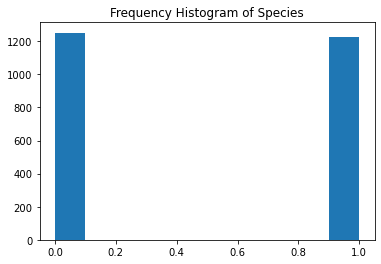

<Figure size 864x864 with 0 Axes>

In [32]:
plt.hist(train['DID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [7]:
# Function for ploting images

def plot_images(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12,12))
    defect_files = train['FILE'][train['CATEGORY'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(DATA_DIR, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

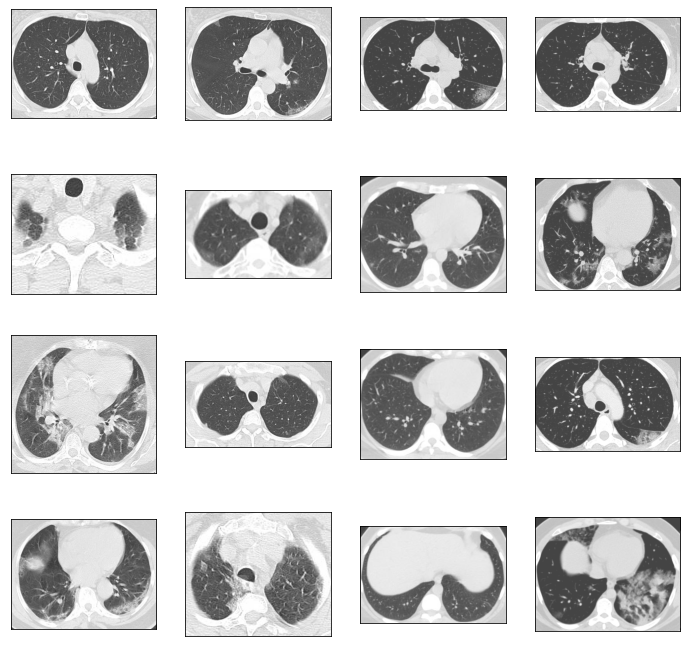

In [8]:
# Displaying images of COVID class from training set

plot_images('COVID', 4, 4)

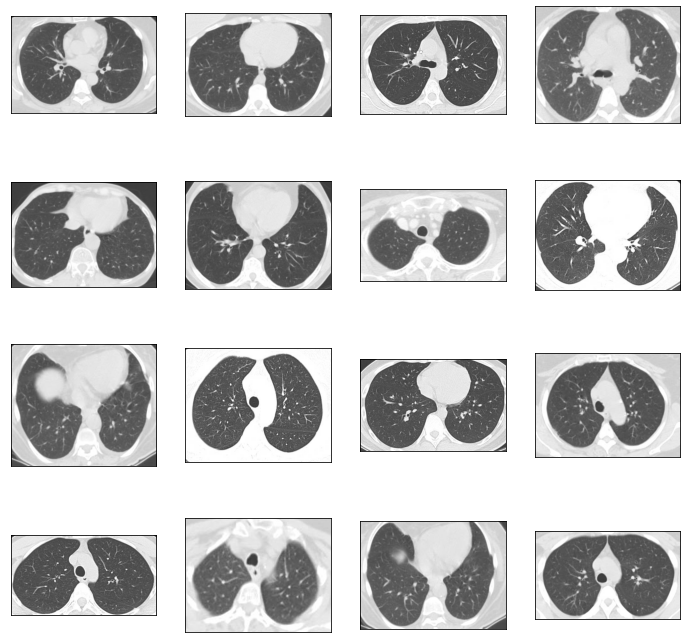

In [9]:
# Displaying images of non-COVID class from training set

plot_images('non-COVID', 4, 4)

In [10]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(DATA_DIR, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# Reading the images and resizing them to target size
for i, file in tqdm(enumerate(train['FILE'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        
# Normalize the training dataset
X_train = X_train / 255.

print('Train Shape: {}'.format(X_train.shape))

2481it [00:22, 110.59it/s]


Train Shape: (2481, 64, 64, 3)


In [12]:
# Converting Labels to Categorical

from keras.utils.np_utils import to_categorical

Y_train = train['DID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [13]:
from sklearn.model_selection import train_test_split

# Spliting into the training and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=47)

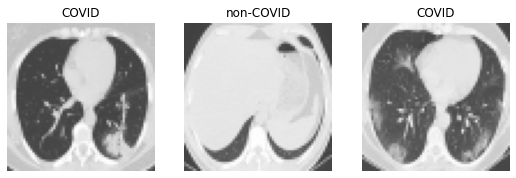

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9,9))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(CATEGORIES[np.argmax(Y_train[i])])

In [15]:
# Setting the epoch, image size, batch size and no of channels

EPOCHS = 12
SIZE = 64
N_CH = 3
BATCH_SIZE = 256

In [16]:
# Creating the MobileNetV2 model

import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,load_model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D,BatchNormalization
from keras.layers import AveragePooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import MobileNet

def build_mobilenet():
    mobile = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_CH))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = mobile(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 
    # model
    model = Model(input,output)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.002, beta_1=0.9, 
                                 beta_2=0.999, epsilon=0.1, decay=0.0), 
                  metrics=['accuracy'])
    
    model.summary()

    return model

In [17]:
# Performing Data Augmentation to prevent overfitting when training the model.

model = build_mobilenet()

annealer = ReduceLROnPlateau(monitor='val_accuracy', 
                             factor=0.5, patience=5, 
                             verbose=1, min_lr=1e-3)

checkpoint = ModelCheckpoint('MobileNetV2.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                             

In [18]:
# Training the model

hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                epochs=EPOCHS,
                verbose=2,
                callbacks=[annealer, checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/12

Epoch 1: val_loss improved from inf to 0.70167, saving model to MobileNetV2.h5
8/8 - 22s - loss: 1.2802 - accuracy: 0.5116 - val_loss: 0.7017 - val_accuracy: 0.5453 - lr: 0.0020 - 22s/epoch - 3s/step
Epoch 2/12

Epoch 2: val_loss did not improve from 0.70167
8/8 - 17s - loss: 1.2676 - accuracy: 0.5106 - val_loss: 0.7287 - val_accuracy: 0.4889 - lr: 0.0020 - 17s/epoch - 2s/step
Epoch 3/12

Epoch 3: val_loss did not improve from 0.70167
8/8 - 17s - loss: 1.2373 - accuracy: 0.5146 - val_loss: 0.7283 - val_accuracy: 0.4869 - lr: 0.0020 - 17s/epoch - 2s/step
Epoch 4/12

Epoch 4: val_loss did not improve from 0.70167
8/8 - 17s - loss: 1.1365 - accuracy: 0.5333 - val_loss: 0.7105 - val_accuracy: 0.5292 - lr: 0.0020 - 17s/epoch - 2s/step
Epoch 5/12

Epoch 5: val_loss improved from 0.70167 to 0.69902, saving model to MobileNetV2.h5
8/8 - 17s - loss: 1.1419 - accuracy: 0.5368 - val_loss: 0.6990 - val_accuracy: 0.5372 - lr: 0.0020 - 17s/epoch - 2s/step
Epoch 6/12

Epoch 6: val_loss im

In [19]:
# Final loss and accuracy of the model

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 62ms/step - loss: 0.7284 - accuracy: 0.5392
Final Loss: 0.7284343242645264, Final Accuracy: 0.5392354130744934


16/16 [==============================] - 2s 61ms/step


Text(0.5, 103.73999999999997, 'Predicted')

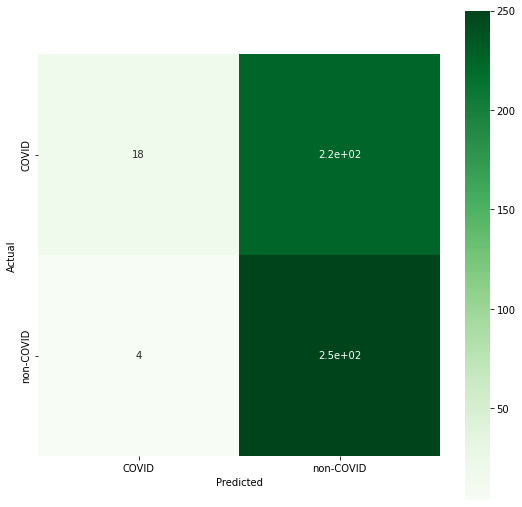

In [20]:
# Plotting the Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

In [25]:
TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Calc true positive rate
TPR = TP/(TP+FN)
print("True positive rate ",TPR)
# Calc true negative rate
TNR = TN/(TN+FP)
print("True negative rate ",TNR)
# Calc positive predictive value
PPV = TP/(TP+FP)
# Calc negative predictive value
NPV = TN/(TN+FN)
# Calc false positive rate
FPR = FP/(FP+TN)
print("False positive rate",FPR)
# Calc false negative rate
FNR = FN/(TP+FN)
print("False negative rate",FNR)
# Calc false discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy   ",ACC)

True positive rate  0.984251968503937
True negative rate  0.07407407407407407
False positive rate 0.9259259259259259
False negative rate 0.015748031496062992
Overall accuracy    0.5392354124748491


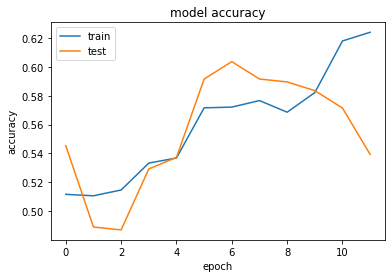

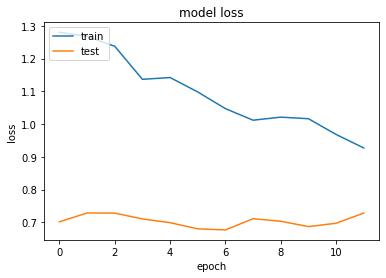

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 21ms/step
[0.20287026 0.7971297 ]


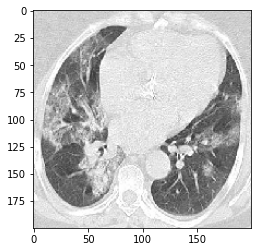

Prediction made: Non Covid-19


In [24]:
# Performing prediction

from skimage import io
import keras
import tensorflow as tf

img = keras.utils.load_img('sars/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img = keras.utils.load_img('sars/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
CATEGORIES = ['Covid-19','Non Covid-19']
x = tf.keras.utils.img_to_array (img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction made:',CATEGORIES[ind])